# Personal Life Dashboard: Correlating Daily Metrics

This notebook serves as a personal "life dashboard" to explore the relationships between various aspects of daily life: **sleep, mood, productivity, and weather**.

Since collecting this data can be time-consuming, we'll start by generating a synthetic dataset that mimics real-world patterns. We'll then use this data to perform:
1.  **Exploratory Data Analysis (EDA):** Visualizing each metric individually.
2.  **Correlation Analysis:** Finding connections between the different data points.
3.  **Insight Generation:** Answering questions like "Does more sleep lead to higher productivity?" or "How does rainy weather affect my mood?".

**Libraries we'll use:**
*   `pandas` for data manipulation.
*   `numpy` for numerical operations.
*   `matplotlib` and `seaborn` for data visualization.
*   `scikit-learn` for a simple predictive model.

In [1]:
# --- 1. Setup: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Set some nice defaults for our plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Generation

This is a key step. We'll create a function to generate a realistic-looking dataset for 90 days. We'll intentionally build some relationships into the data so we can discover them later. For example:
*   Good sleep will positively influence mood and productivity.
*   Sunny weather will have a slight positive effect on mood.
*   High productivity might slightly boost mood.

In [2]:
def generate_life_data(days=90):
    """Generates a DataFrame with synthetic life data."""
    
    start_date = date.today() - timedelta(days=days)
    dates = [start_date + timedelta(days=i) for i in range(days)]
    
    data = []
    
    for d in dates:
        # --- Sleep Data ---
        # Normally distributed around 7.5 hours
        sleep_hours = np.random.normal(loc=7.5, scale=1.2)
        sleep_hours = max(4, min(10, sleep_hours)) # Clamp values between 4 and 10
        # Sleep quality influenced by hours, but with randomness
        sleep_quality = (sleep_hours / 10) * 5 + np.random.normal(0, 0.5)
        sleep_quality = max(1, min(5, sleep_quality)) # Clamp to 1-5 scale

        # --- Weather Data ---
        weather_conditions = ['Sunny', 'Cloudy', 'Rainy']
        weather = np.random.choice(weather_conditions, p=[0.5, 0.3, 0.2])
        if weather == 'Sunny':
            temperature = np.random.randint(20, 30)
        elif weather == 'Cloudy':
            temperature = np.random.randint(15, 22)
        else: # Rainy
            temperature = np.random.randint(10, 18)
            
        # --- Productivity & Mood (The correlated parts) ---
        # Let's define base values and then add effects
        base_productivity = np.random.uniform(3, 7)
        base_mood = np.random.uniform(4, 8)
        
        # Effect of sleep on productivity and mood
        sleep_bonus_prod = (sleep_hours - 7.5) * 0.8
        sleep_bonus_mood = (sleep_quality - 3) * 0.7
        
        # Effect of weather on mood
        weather_mood_effect = 0
        if weather == 'Sunny':
            weather_mood_effect = 0.8
        elif weather == 'Rainy':
            weather_mood_effect = -1.0
            
        # Calculate final scores (1-10 scale)
        productivity_score = base_productivity + sleep_bonus_prod
        mood_score = base_mood + sleep_bonus_mood + weather_mood_effect
        
        # Add a little random noise
        productivity_score += np.random.normal(0, 0.5)
        mood_score += np.random.normal(0, 0.5)

        # Clamp final scores to be within 1-10
        productivity_score = round(max(1, min(10, productivity_score)), 1)
        mood_score = round(max(1, min(10, mood_score)), 1)
        
        data.append({
            "Date": d,
            "Sleep_Hours": round(sleep_hours, 1),
            "Sleep_Quality": round(sleep_quality, 1),
            "Weather": weather,
            "Temperature_C": temperature,
            "Productivity": productivity_score,
            "Mood": mood_score
        })
        
    df = pd.DataFrame(data)
    df.set_index('Date', inplace=True)
    return df

# Generate our data!
df = generate_life_data(days=180)

print("Synthetic data generated successfully!")
df.head()

Synthetic data generated successfully!


,Sleep_Hours,Sleep_Quality,Weather,Temperature_C,Productivity,Mood
Date,,,,,,
2025-01-01,6.6,4.3,Rainy,12,5.9,5.0
2025-01-02,8.9,3.8,Rainy,12,5.0,3.6
2025-01-03,9.8,5.0,Sunny,28,6.1,5.4
2025-01-04,7.6,3.2,Sunny,24,5.6,6.0
2025-01-05,7.5,3.4,Sunny,24,3.2,7.3


## 3. Exploratory Data Analysis (EDA)

Let's look at our data. We'll start by visualizing each variable over time and looking at its distribution.

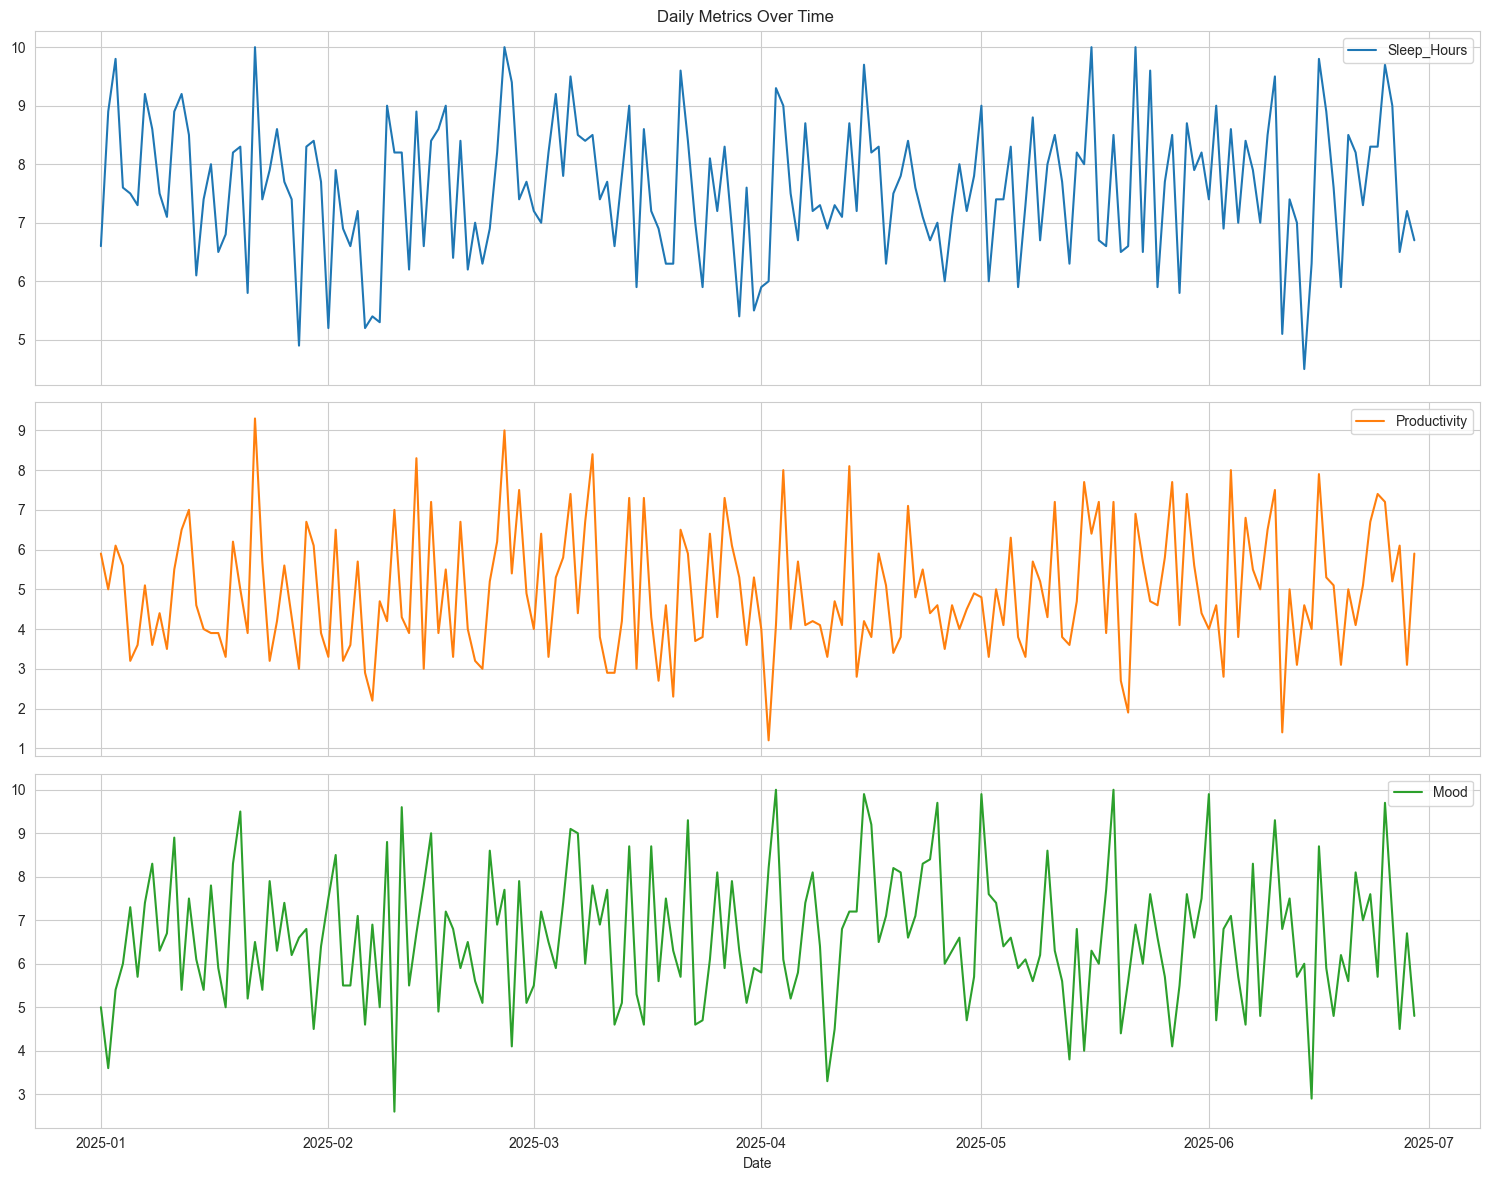

In [3]:
# --- Time Series Plot of All Metrics ---
df[['Sleep_Hours', 'Productivity', 'Mood']].plot(
    title='Daily Metrics Over Time', 
    subplots=True, 
    layout=(3,1), 
    figsize=(15, 12),
    sharex=True
)
plt.tight_layout()
plt.show()

C:\Users\Kathit\AppData\Local\Temp\ipykernel_18876\1047351545.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weather', data=df, ax=axes[1, 1], palette='viridis').set_title('Weather Condition Counts')


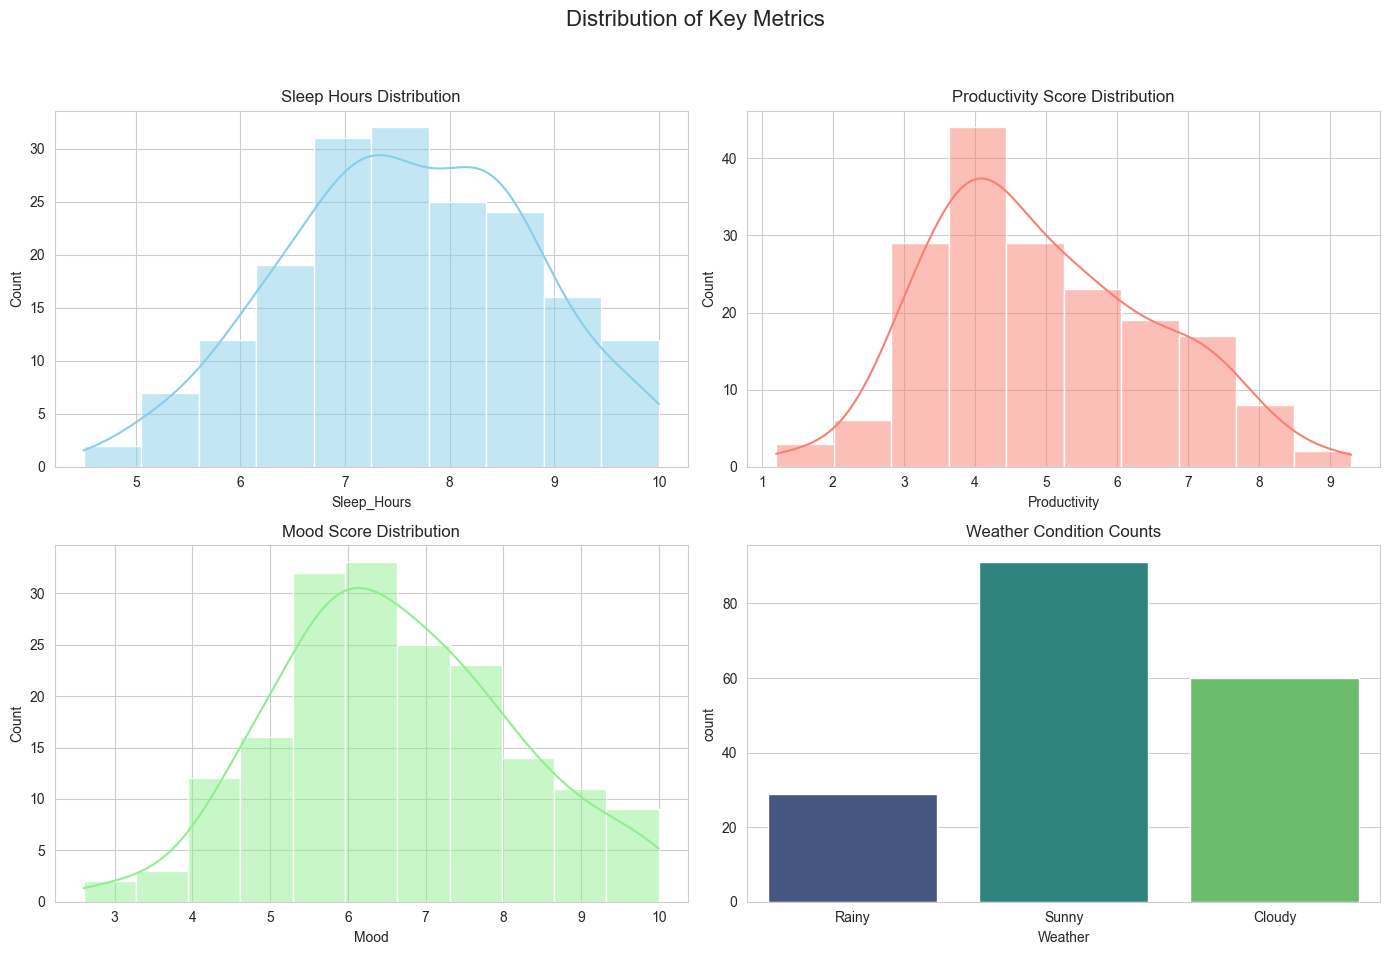

In [4]:
# --- Distribution of Key Metrics ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Key Metrics', fontsize=16)

sns.histplot(df['Sleep_Hours'], kde=True, ax=axes[0, 0], color='skyblue').set_title('Sleep Hours Distribution')
sns.histplot(df['Productivity'], kde=True, ax=axes[0, 1], color='salmon').set_title('Productivity Score Distribution')
sns.histplot(df['Mood'], kde=True, ax=axes[1, 0], color='lightgreen').set_title('Mood Score Distribution')
sns.countplot(x='Weather', data=df, ax=axes[1, 1], palette='viridis').set_title('Weather Condition Counts')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Correlation Analysis

This is the core of our dashboard. We want to see how these variables relate to each other.

### 4.1. Correlation Heatmap

A heatmap gives us a quick, high-level overview of the linear relationships between all numeric variables. A value close to 1 means a strong positive correlation, while a value close to -1 means a strong negative correlation.

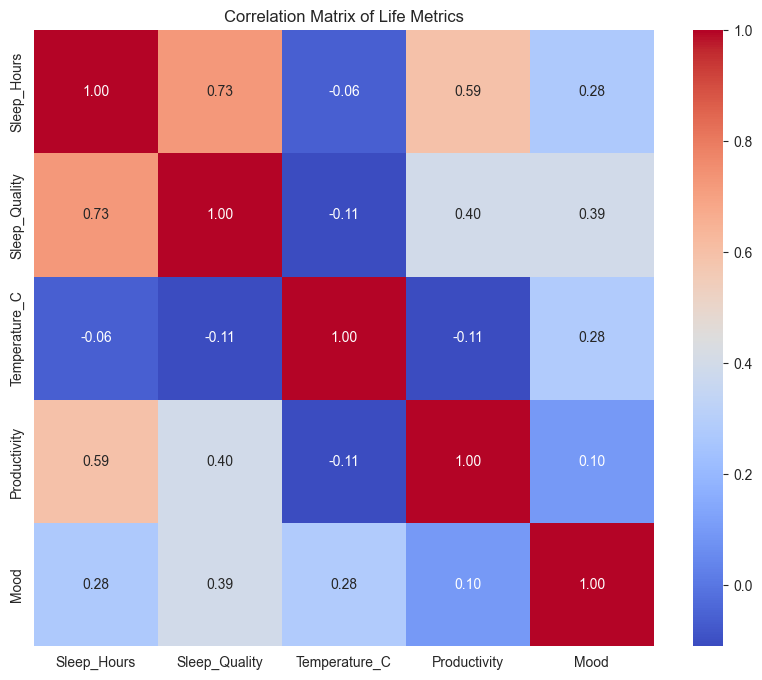

In [5]:
# Calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Life Metrics')
plt.show()

### 4.2. Deep Dive: Specific Relationships

The heatmap gives us clues. Now let's visualize specific relationships to understand them better.

**Question 1: How does sleep affect productivity and mood?**

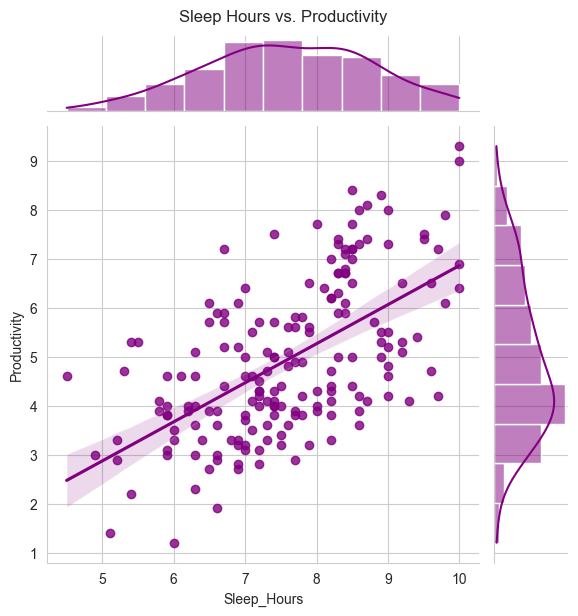

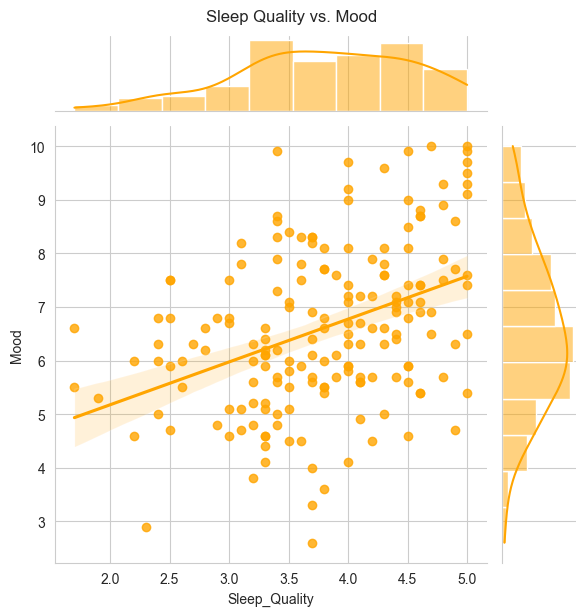

In [6]:
# Using jointplot to see both the scatter plot and distributions
sns.jointplot(x='Sleep_Hours', y='Productivity', data=df, kind='reg', color='purple')
plt.suptitle('Sleep Hours vs. Productivity', y=1.02)
plt.show()

sns.jointplot(x='Sleep_Quality', y='Mood', data=df, kind='reg', color='orange')
plt.suptitle('Sleep Quality vs. Mood', y=1.02)
plt.show()

**Question 2: How does the weather impact mood and productivity?**

For categorical data like 'Weather', box plots or violin plots are excellent for comparing distributions.

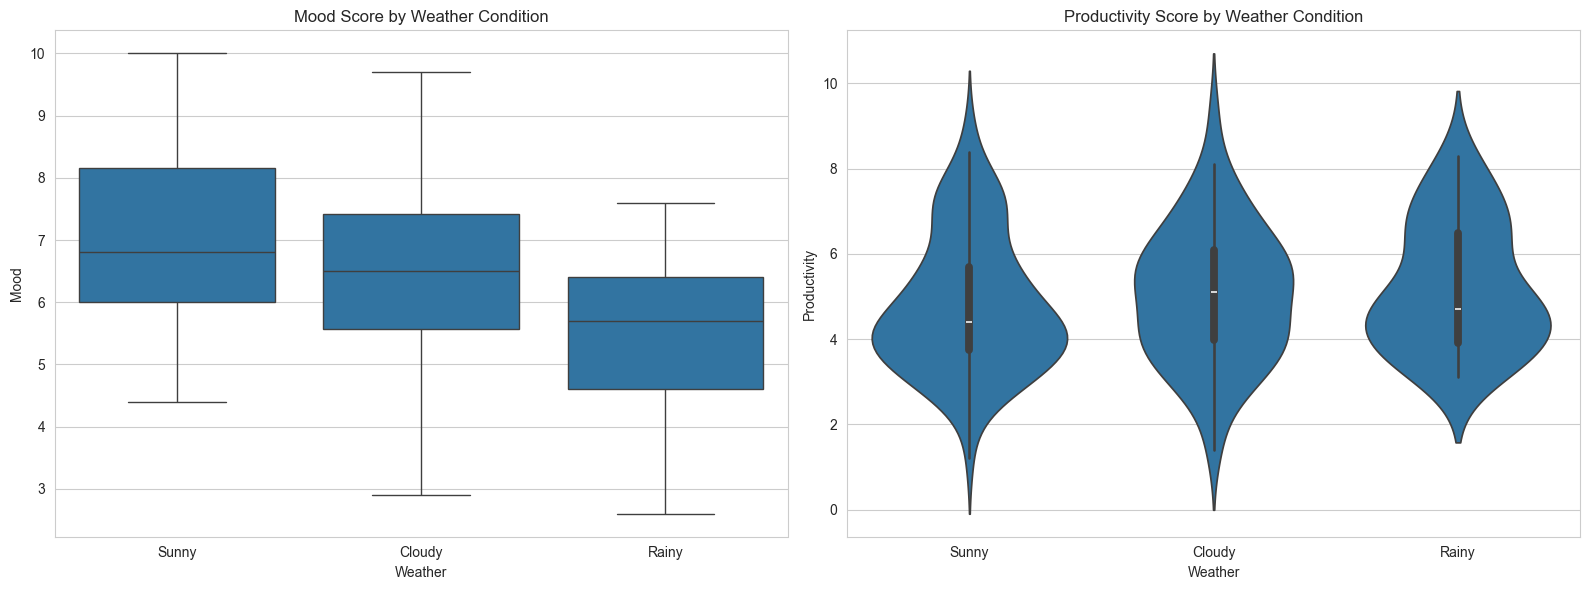

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Weather vs. Mood
sns.boxplot(x='Weather', y='Mood', data=df, ax=axes[0], order=['Sunny', 'Cloudy', 'Rainy'])
axes[0].set_title('Mood Score by Weather Condition')

# Weather vs. Productivity
sns.violinplot(x='Weather', y='Productivity', data=df, ax=axes[1], order=['Sunny', 'Cloudy', 'Rainy'])
axes[1].set_title('Productivity Score by Weather Condition')

plt.tight_layout()
plt.show()

### 4.3. The All-in-One Dashboard View

A `pairplot` is a fantastic tool that creates a grid of scatterplots for every pair of variables. It allows us to see all relationships at once.

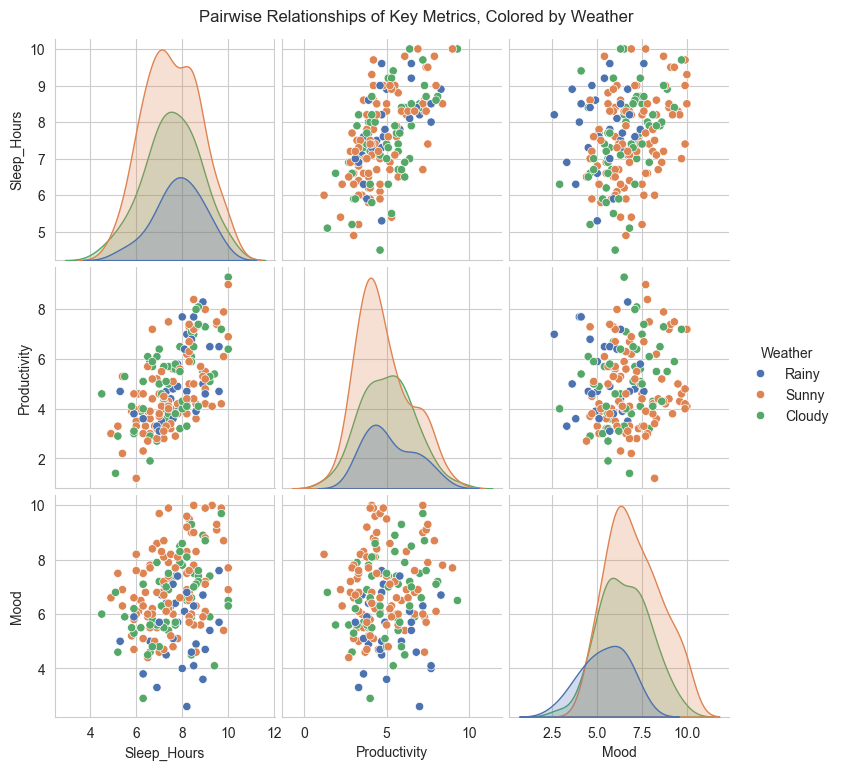

In [8]:
# Use a subset of columns for clarity
pairplot_df = df[['Sleep_Hours', 'Productivity', 'Mood', 'Weather']]

sns.pairplot(pairplot_df, hue='Weather', palette='deep')
plt.suptitle('Pairwise Relationships of Key Metrics, Colored by Weather', y=1.02)
plt.show()

## 5. Simple Predictive Modeling 

Can we predict our productivity for the day based on other factors? Let's build a simple linear regression model to find out. This also helps quantify the relationships we observed.

**Goal:** Predict `Productivity`.
**Features:** `Sleep_Hours`, `Sleep_Quality`, and `Weather`.

In [9]:
# --- Prepare data for modeling ---
# We need to convert the 'Weather' category into numbers. One-hot encoding is perfect for this.
model_df = pd.get_dummies(df, columns=['Weather'], drop_first=True)

# Define our features (X) and target (y)
features = ['Sleep_Hours', 'Sleep_Quality', 'Weather_Rainy', 'Weather_Sunny']
X = model_df[features]
y = model_df['Productivity']

# --- Train the model ---
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# --- Interpret the results ---
print(f"Model R-squared on test data: {model.score(X_test, y_test):.2f}")
print("\n--- Model Coefficients ---")

# Create a nice summary of the coefficients
coeffs = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coeffs)

print("\n--- Interpretation ---")
print("These coefficients tell us the expected change in Productivity for a one-unit change in the feature, holding all others constant.")
print(f"For example, a 1-hour increase in sleep is associated with a {coeffs.loc['Sleep_Hours'].values[0]:.2f} point increase in productivity.")

Model R-squared on test data: 0.32

--- Model Coefficients ---
               Coefficient
Sleep_Hours       0.806785
Sleep_Quality    -0.100036
Weather_Rainy     0.023186
Weather_Sunny    -0.351401

--- Interpretation ---
These coefficients tell us the expected change in Productivity for a one-unit change in the feature, holding all others constant.
For example, a 1-hour increase in sleep is associated with a 0.81 point increase in productivity.


## 6. Conclusion & Next Steps

From our synthetic data, we've drawn several conclusions:
*   **Sleep is a major driver:** Both sleep duration and quality strongly correlate with better mood and higher productivity.
*   **Weather has a noticeable effect on mood:** Sunny days provide a mood boost, while rainy days can have a negative impact. Its effect on productivity seems less direct in our data.
*   **These factors are interconnected:** A good day is often a combination of several positive factors.

### How to Use This for Your Own Life

1.  **Start Collecting Data:**
    *   **Sleep:** Use a fitness tracker (Fitbit, Oura, Whoop) or a sleep tracking app.
    *   **Mood & Productivity:** A simple daily journal (e.g., in a spreadsheet, Notion, or a dedicated app like Daylio) where you rate your day from 1-10 is a great start.
    *   **Weather:** You can use a free weather API to automatically pull historical data for your location.

2.  **Populate Your DataFrame:** Once you have a month or two of data, replace the `generate_life_data` function with code that loads your own CSV or spreadsheet.

3.  **Re-run and Analyze:** Re-run the notebook to discover *your* personal patterns and find out what truly drives your well-being and effectiveness.